# Firing Rate

In [3]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
base_path = os.path.dirname(os.getcwd())  # parent of 'notebooks'
sys.path.insert(1, base_path)

from scripts.helpers import *
from scripts.utils import remove_top_right_frame, jitter_scatterplot

In [5]:
data_df = pd.read_pickle('/Users/raphaelpax/Desktop/neuroscience/BIO482_MiniProject_2025_Python/Data/Data_bio482.pkl')

In [6]:
data_df.head(5)

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]"
1,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006..."
2,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]"
3,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,4.0,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1..."
4,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,5.0,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2..."


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
import scipy.stats

# === 1. Compute spike count & firing rate per sweep ==================

def compute_spike_count(vm_trace, fs, height=-20, distance_ms=2.0):
    """
    Detect spikes from Vm trace using a simple peak detector.
    
    vm_trace : array-like (mV)
    fs       : sampling rate (Hz)
    height   : minimal peak height (mV) to be considered an AP
    distance_ms : minimal distance between spikes (ms)
    """
    if not isinstance(vm_trace, (list, np.ndarray)):
        return np.nan
    
    vm = np.array(vm_trace, dtype=float)
    if vm.size == 0 or pd.isna(fs):
        return np.nan
    
    min_distance_samples = int(distance_ms * 1e-3 * fs)
    peaks, _ = find_peaks(vm, height=height, distance=min_distance_samples)
    return len(peaks)


def compute_firing_rate(vm_trace, fs, height=-20, distance_ms=2.0):
    """
    Compute firing rate (Hz) from Vm trace + sampling frequency.
    """
    if not isinstance(vm_trace, (list, np.ndarray)):
        return np.nan
    vm = np.array(vm_trace, dtype=float)
    if vm.size == 0 or pd.isna(fs):
        return np.nan
    
    duration_s = vm.size / fs  # sweep duration in seconds
    if duration_s <= 0:
        return np.nan
    
    spike_count = compute_spike_count(vm, fs, height=height, distance_ms=distance_ms)
    if np.isnan(spike_count):
        return np.nan
    
    return spike_count / duration_s


# Apply to each sweep
data_df["Sweep_SpikeCount"] = data_df.apply(
    lambda row: compute_spike_count(
        row["Sweep_MembranePotential"],
        row["Sweep_MembranePotential_SamplingRate"],
        height=-20,        # ⚠️ à adapter à tes données si besoin
        distance_ms=2.0
    ),
    axis=1,
)

data_df["Sweep_FiringRate_Hz"] = data_df.apply(
    lambda row: compute_firing_rate(
        row["Sweep_MembranePotential"],
        row["Sweep_MembranePotential_SamplingRate"],
        height=-20,
        distance_ms=2.0
    ),
    axis=1,
)

display(
    data_df[
        ["Cell_ID", "Cell_Layer", "Sweep_Counter",
         "Sweep_SpikeCount", "Sweep_FiringRate_Hz"]
    ].head()
)


,Cell_ID,Cell_Layer,Sweep_Counter,Sweep_SpikeCount,Sweep_FiringRate_Hz
0,SC901_1,L2/3,1.0,7896,394.80
1,SC901_1,L2/3,2.0,7757,387.85
2,SC901_1,L2/3,3.0,7709,385.45
3,SC901_1,L2/3,4.0,7595,379.75
4,SC901_1,L2/3,5.0,7700,385.00


In [8]:
# === 2. Build / extend the per-cell dataframe with firing stats =====

# Meta (1 ligne par cellule)
meta_cols = [
    "Cell_ID", "Cell_Layer", "Cell_Depth", "Cell_Type",
    "Cell_TargetedBrainArea", "Cell_APThreshold_Slope"
]
cell_meta = (
    data_df
    .drop_duplicates(subset=["Cell_ID"])[meta_cols]
    .set_index("Cell_ID")
)

# Firing stats per cell
cell_fr_stats = (
    data_df
    .groupby("Cell_ID")
    .agg(
        mean_fr_over_sweeps=("Sweep_FiringRate_Hz", "mean"),
        std_fr_over_sweeps=("Sweep_FiringRate_Hz", "std"),
        median_fr_over_sweeps=("Sweep_FiringRate_Hz", "median"),
        n_sweeps=("Sweep_FiringRate_Hz", "count")
    )
)

# If you already had a cell_df from the Vm analysis:
try:
    cell_df = cell_df.set_index("Cell_ID").join(cell_fr_stats, how="inner")
    cell_df = cell_df.join(cell_meta, how="left")
    cell_df = cell_df.reset_index()
except NameError:
    # If cell_df does not exist yet, create it from scratch
    cell_df = cell_meta.join(cell_fr_stats, how="inner").reset_index()

display(cell_df.head())


,Cell_ID,Cell_Layer,Cell_Depth,Cell_Type,Cell_TargetedBrainArea,Cell_APThreshold_Slope,mean_fr_over_sweeps,std_fr_over_sweeps,median_fr_over_sweeps,n_sweeps
0,SC901_1,L2/3,229.0,EXC,C2,10.0,384.814286,5.730162,385.000,7
1,SC902_1,L2/3,350.0,EXC,C2,10.0,406.900000,6.109214,408.500,3
2,SC903_1,L5,550.0,EXC,C2,10.0,404.100000,NaN,404.100,1
3,SC904_1,L2/3,244.0,EXC,C2,10.0,425.183333,1.014232,425.325,6
4,SC905_1,L2/3,250.0,EXC,C2,10.0,419.558333,5.809683,419.050,6


In [9]:
# === 3.1. Descriptif firing rate par couche ========================

layer_fr_summary = (
    cell_df
    .groupby("Cell_Layer")
    .agg(
        n_cells=("Cell_ID", "count"),
        mean_fr=("mean_fr_over_sweeps", "mean"),
        std_fr=("mean_fr_over_sweeps", "std"),
        median_fr=("mean_fr_over_sweeps", "median"),
        mean_depth=("Cell_Depth", "mean"),
        std_depth=("Cell_Depth", "std")
    )
    .sort_values("mean_depth")
)

display(layer_fr_summary)


,n_cells,mean_fr,std_fr,median_fr,mean_depth,std_depth
Cell_Layer,,,,,,
L2/3,141,393.976406,24.371544,401.083333,228.834532,88.188664
L4,79,397.130371,17.745275,400.008333,458.139241,42.793701
L5,20,396.661667,15.429013,399.745833,581.050000,44.298598


/var/folders/62/hhx0hr3x0593xyr49y92dcsh0000gn/T/ipykernel_90947/3371345065.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


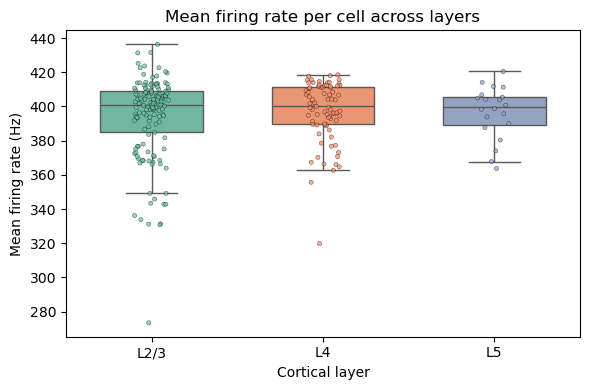

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

layers = sorted(cell_df["Cell_Layer"].unique())
palette = dict(zip(layers, sns.color_palette("Set2", n_colors=len(layers))))

sns.boxplot(
    data=cell_df,
    x="Cell_Layer",
    y="mean_fr_over_sweeps",
    order=layers,
    palette=palette,
    width=0.6,
    showfliers=False,  # optionnel : plus propre si on met les points
)

sns.stripplot(
    data=cell_df,
    x="Cell_Layer",
    y="mean_fr_over_sweeps",
    order=layers,
    hue="Cell_Layer",
    palette=palette,
    dodge=False,
    size=3,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.3,
    legend=False,
)

plt.ylabel("Mean firing rate (Hz)")
plt.xlabel("Cortical layer")
plt.title("Mean firing rate per cell across layers")
plt.tight_layout()
plt.show()



Correlation depth–firing rate: r = -0.004, p = 9.458e-01


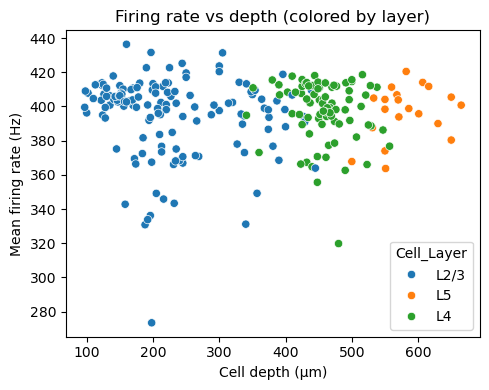

In [11]:
# === 4.1. Corrélation firing rate vs profondeur ====================

valid = cell_df.dropna(subset=["Cell_Depth", "mean_fr_over_sweeps"])
r, p = scipy.stats.pearsonr(
    valid["Cell_Depth"],
    valid["mean_fr_over_sweeps"]
)
print(f"Correlation depth–firing rate: r = {r:.3f}, p = {p:.3e}")

plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=valid,
    x="Cell_Depth",
    y="mean_fr_over_sweeps",
    hue="Cell_Layer"
)
plt.xlabel("Cell depth (µm)")
plt.ylabel("Mean firing rate (Hz)")
plt.title("Firing rate vs depth (colored by layer)")
plt.tight_layout()
plt.show()


In [12]:
# === 4.2. Régression firing rate ~ profondeur dans chaque couche ===

layers = sorted(cell_df["Cell_Layer"].dropna().unique())
layer_fr_reg_results = []

for layer in layers:
    sub = cell_df.dropna(subset=["Cell_Depth", "mean_fr_over_sweeps"])
    sub = sub[sub["Cell_Layer"] == layer]
    if len(sub) < 3:
        continue  # pas assez de cellules pour une régression fiable
    
    X = sub[["Cell_Depth"]].values
    y = sub["mean_fr_over_sweeps"].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)
    
    layer_fr_reg_results.append(
        {
            "Cell_Layer": layer,
            "n_cells": len(sub),
            "slope_fr_per_um": slope,
            "intercept": intercept,
            "r2": r2,
        }
    )

layer_fr_reg_df = pd.DataFrame(layer_fr_reg_results)
display(layer_fr_reg_df)


,Cell_Layer,n_cells,slope_fr_per_um,intercept,r2
0,L2/3,139,-0.029779,401.609596,0.012438
1,L4,79,-0.050020,420.046628,0.014551
2,L5,20,0.102083,337.346540,0.085903


In [13]:
# === 5. Mean firing rate par couche et type de cellule ============

pivot_fr_layer_type = pd.pivot_table(
    cell_df,
    index="Cell_Layer",
    columns="Cell_Type",
    values="mean_fr_over_sweeps",
    aggfunc="mean"
)

display(pivot_fr_layer_type)


Cell_Type,EXC,PV,SST,VIP
Cell_Layer,,,,
L2/3,405.510418,359.160815,400.264098,405.522999
L4,409.875185,373.733294,396.171866,NaN
L5,403.426786,367.766667,392.962500,377.188889


In [25]:
# --- Create depth bins (population categories by depth) -------------
depth_bins = np.arange(0, cell_df["Cell_Depth"].max() + 100, 100)
cell_df["DepthBin"] = pd.cut(cell_df["Cell_Depth"], bins=depth_bins)

display(cell_df[["Cell_ID", "Cell_Layer", "Cell_Type", "Cell_Depth", "DepthBin"]].head())


,Cell_ID,Cell_Layer,Cell_Type,Cell_Depth,DepthBin
0,SC901_1,L2/3,EXC,229.0,"(200.0, 300.0]"
1,SC902_1,L2/3,EXC,350.0,"(300.0, 400.0]"
2,SC903_1,L5,EXC,550.0,"(500.0, 600.0]"
3,SC904_1,L2/3,EXC,244.0,"(200.0, 300.0]"
4,SC905_1,L2/3,EXC,250.0,"(200.0, 300.0]"


# Population-level dependencies

In [30]:
# --- Create depth bins (population categories by depth) -------------
depth_bins = np.arange(0, cell_df["Cell_Depth"].max() + 100, 100)
cell_df["DepthBin"] = pd.cut(cell_df["Cell_Depth"], bins=depth_bins)

display(cell_df[["Cell_ID", "Cell_Layer", "Cell_Type", "Cell_Depth", "DepthBin"]].head())


,Cell_ID,Cell_Layer,Cell_Type,Cell_Depth,DepthBin
0,SC901_1,L2/3,EXC,229.0,"(200.0, 300.0]"
1,SC902_1,L2/3,EXC,350.0,"(300.0, 400.0]"
2,SC903_1,L5,EXC,550.0,"(500.0, 600.0]"
3,SC904_1,L2/3,EXC,244.0,"(200.0, 300.0]"
4,SC905_1,L2/3,EXC,250.0,"(200.0, 300.0]"


In [31]:
# === Population-level FR by layer ====================================

pop_layer_fr = (
    cell_df
    .groupby("Cell_Layer")
    .agg(
        pop_mean_fr=("mean_fr_over_sweeps", "mean"),
        pop_std_fr=("mean_fr_over_sweeps", "std"),
        pop_sem_fr=("mean_fr_over_sweeps", lambda x: np.std(x) / np.sqrt(len(x))),
        n_cells=("Cell_ID", "count")
    )
    .sort_values("pop_mean_fr")
)

display(pop_layer_fr)


,pop_mean_fr,pop_std_fr,pop_sem_fr,n_cells
Cell_Layer,,,,
L2/3,393.976406,24.371544,2.045163,141
L5,396.661667,15.429013,3.362676,20
L4,397.130371,17.745275,1.983823,79


In [32]:
# === Population-level FR by Layer × Type ============================

pop_layer_type_fr = (
    cell_df
    .groupby(["Cell_Layer", "Cell_Type"])
    .agg(
        pop_mean_fr=("mean_fr_over_sweeps", "mean"),
        pop_std_fr=("mean_fr_over_sweeps", "std"),
        pop_sem_fr=("mean_fr_over_sweeps", lambda x: np.std(x) / np.sqrt(len(x))),
        n_cells=("Cell_ID", "count")
    )
)

display(pop_layer_type_fr)


pop_mean_fr  pop_std_fr  pop_sem_fr  n_cells
Cell_Layer Cell_Type                                              
L2/3       EXC         405.510418   24.023788    3.580330       44
           PV          359.160815   16.012466    2.874326       30
           SST         400.264098    7.732350    1.139791       45
           VIP         405.522999    7.997756    1.665924       22
L4         EXC         409.875185    7.544149    1.256845       35
           PV          373.733294   17.739242    4.063376       18
           SST         396.171866    8.281486    1.592593       26
L5         EXC         403.426786   10.204696    2.628111       14
           PV          367.766667         NaN    0.000000        1
           SST         392.962500    7.642646    3.821323        2
           VIP         377.188889   15.334070    7.228550        3

In [33]:
# === Population-level FR by depth bin ================================

pop_depthbin_fr = (
    cell_df
    .groupby("DepthBin")
    .agg(
        pop_mean_fr=("mean_fr_over_sweeps", "mean"),
        pop_std_fr=("mean_fr_over_sweeps", "std"),
        pop_sem_fr=("mean_fr_over_sweeps", lambda x: np.std(x) / np.sqrt(len(x))),
        n_cells=("Cell_ID", "count")
    )
)

display(pop_depthbin_fr)


/var/folders/62/hhx0hr3x0593xyr49y92dcsh0000gn/T/ipykernel_90947/397566118.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DepthBin")


,pop_mean_fr,pop_std_fr,pop_sem_fr,n_cells
DepthBin,,,,
"(0.0, 100.0]",401.557198,6.635586,3.128045,3
"(100.0, 200.0]",396.730502,26.879354,3.441071,60
"(200.0, 300.0]",392.647450,21.526779,3.173167,45
"(300.0, 400.0]",395.230773,20.583282,3.581340,32
"(400.0, 500.0]",396.399471,18.322911,2.205581,68
"(500.0, 600.0]",395.867391,15.897353,3.241965,23
"(600.0, 700.0]",399.701984,12.037248,4.212159,7


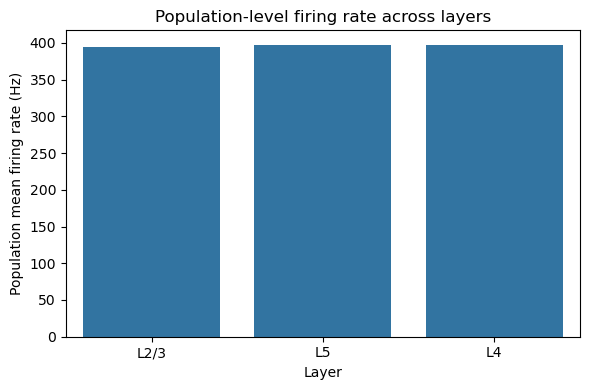

In [39]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=pop_layer_fr.reset_index(),
    x="Cell_Layer",
    y="pop_mean_fr",
    errorbar=("se", 68)  # or "sd", None, etc.
)
plt.ylabel("Population mean firing rate (Hz)")
plt.xlabel("Layer")
plt.title("Population-level firing rate across layers")
plt.tight_layout()
plt.show()


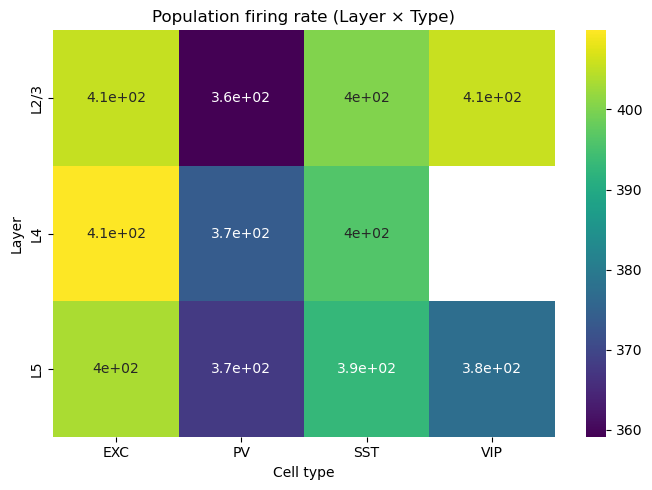

In [35]:
plt.figure(figsize=(7,5))
pivot = pop_layer_type_fr["pop_mean_fr"].unstack("Cell_Type")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title("Population firing rate (Layer × Type)")
plt.xlabel("Cell type")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()


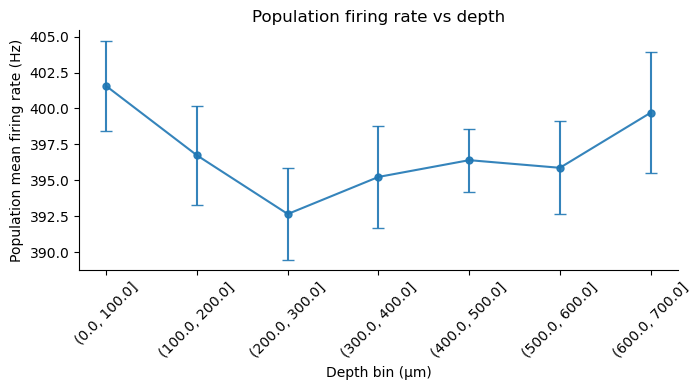

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# If DepthBin is an ordered numeric or categorical, it's nice to sort it first
df = pop_depthbin_fr.reset_index().sort_values("DepthBin")

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=100)

# Clean up spines like in your other plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Line + markers + errorbars
ax.errorbar(
    x=np.arange(len(df)),                  # x positions
    y=df["pop_mean_fr"].values,           # mean FR
    yerr=df["pop_sem_fr"].values,         # SEM
    fmt="-o",                             # line with markers
    capsize=4,
    linewidth=1.5,
    markersize=5,
    alpha=0.9,
)

# Put the actual bin labels on the x-axis
ax.set_xticks(np.arange(len(df)))
ax.set_xticklabels(df["DepthBin"], rotation=45)

ax.set_xlabel("Depth bin (µm)")
ax.set_ylabel("Population mean firing rate (Hz)")
ax.set_title("Population firing rate vs depth")

plt.tight_layout()
plt.show()


In [41]:
# Filter valid rows
valid = pop_depthbin_fr.dropna(subset=["pop_mean_fr"]).reset_index()

# Convert depth bins to midpoints
valid["Depth_midpoint"] = valid["DepthBin"].apply(lambda x: x.mid)

X = valid[["Depth_midpoint"]].values
y = valid["pop_mean_fr"].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

print(f"Population FR ~ Depth  | slope = {slope:.4f} Hz/µm  |  R² = {r2:.3f}")


Population FR ~ Depth  | slope = -0.0013 Hz/µm  |  R² = 0.009


In [ ]:
  # assuming this file contains the Vm analysis and cell_df

# === Vm population averages by layer =================================

pop_layer_vm = (
    cell_df
    .groupby("Cell_Layer")
    .agg(
        pop_mean_vm=("mean_vm_over_sweeps", "mean"),
        pop_std_vm=("mean_vm_over_sweeps", "std"),
        pop_sem_vm=("mean_vm_over_sweeps", lambda x: np.std(x) / np.sqrt(len(x))),
        n_cells=("Cell_ID", "count")
    )
)

display(pop_layer_vm)

ModuleNotFoundError: No module named 'part4_Raph_Vm'